# Disaster Tweets Classifications

Project for udemy course 

In [5]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

## get the data from github

In [6]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

## Explore the data 

In [9]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweet.shape

(7613, 5)

In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

In [ ]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

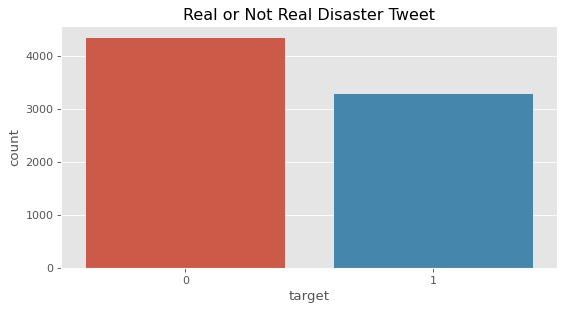

In [ ]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [ ]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

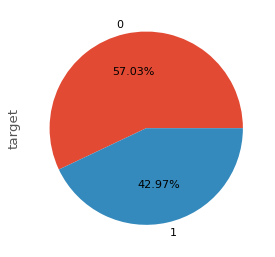

In [ ]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

## Using a Preprocess package from github

In [7]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-g9bwa631
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-g9bwa631
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11743 sha256=00ad0e5294b66925a37276c43676474b740533c5ef7992d2d01d42018f94d7aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-mc9ngjpq/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [8]:
import preprocess_kgptalkie as kgp

In [9]:
tweet = kgp.get_basic_features(tweet)

In [10]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


## Dist plots char counts

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


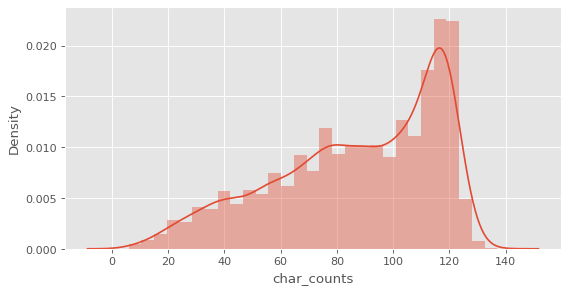

In [ ]:
sns.distplot(tweet['char_counts'])

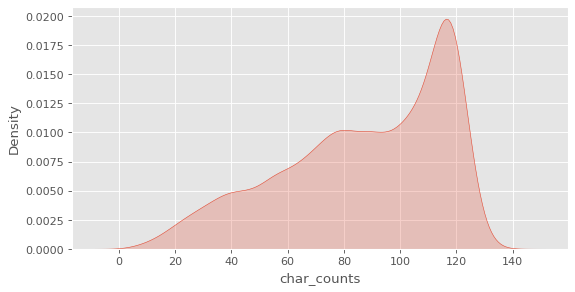

In [ ]:
sns.kdeplot(tweet['char_counts'], shade=True)

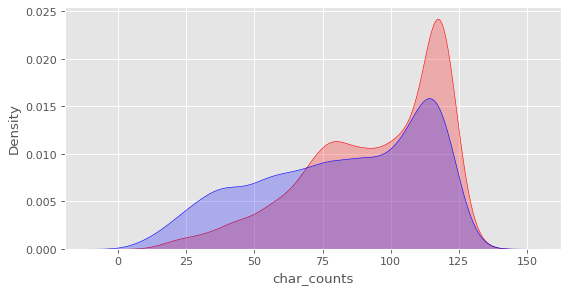

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

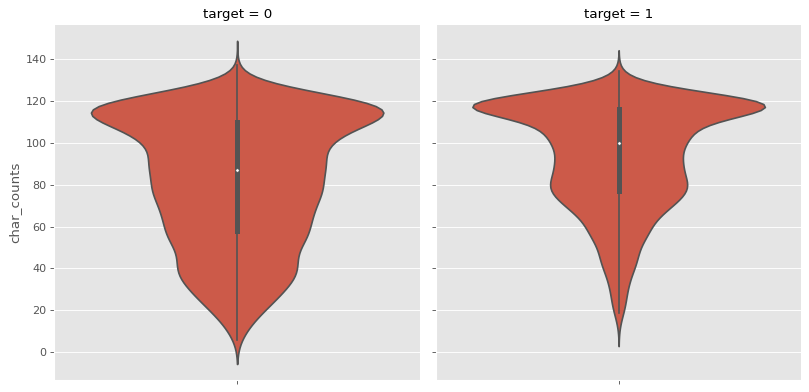

In [ ]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

## Number of words,Avrage Words length,and stop words distribution in tweets 

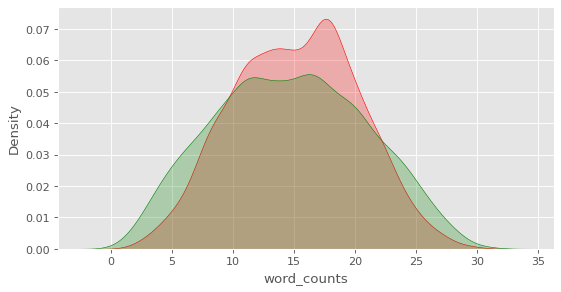

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='green')

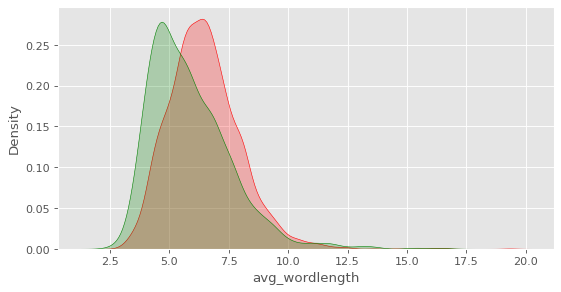

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='green')

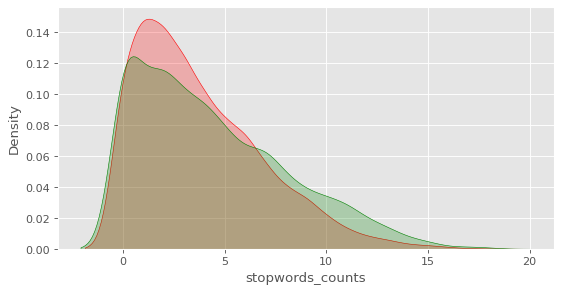

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='green')


## Most and least Common Words in raw data 



In [ ]:
freqs = kgp.get_word_freqs(tweet, 'text')
freqs

the          2575
a            1845
to           1805
in           1757
of           1722
             ... 
'@j2bone:       1
Side            1
ALERT!          1
Homs            1
testimony       1
Length: 31924, dtype: int64

In [ ]:
top20 = freqs[0:20] # all are stop words
#top20 = freqs[100:120]
top20

the     2575
a       1845
to      1805
in      1757
of      1722
and     1302
I       1197
for      820
is       814
on       773
-        763
you      632
The      552
my       549
with     508
that     492
at       485
by       469
it       433
from     372
dtype: int64

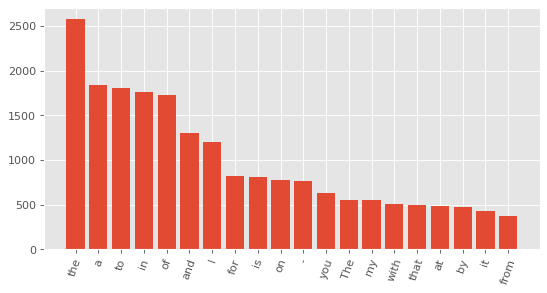

In [ ]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [ ]:
least20 = freqs[-20:]
least20

Butterfinger              1
envision                  1
Activision                1
http://t.co/tN1aX1xMBB    1
EAT                       1
skynet?                   1
http://t.co/H0xUNJ3C7C    1
therapies                 1
veteran's                 1
627%                      1
http://t.co/EGcv7ybjae    1
http://t.co/m2y9Ym3iF6    1
disney                    1
PVC                       1
carnage                   1
'@j2bone:                 1
Side                      1
ALERT!                    1
Homs                      1
testimony                 1
dtype: int64

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [ ]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

## Cleaning the data 

In [11]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x) #I'm -> i am
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [12]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [ ]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

## Word cloud

In [105]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
#real

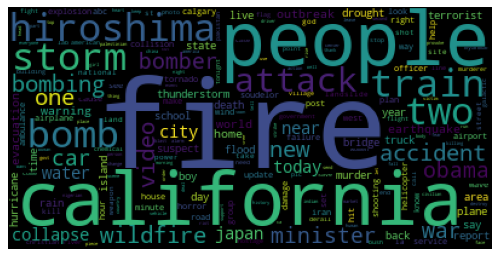

In [ ]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

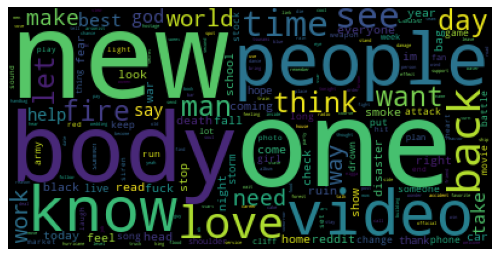

In [ ]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and  SVM



In [43]:
text = tweet['text']
y = tweet['target']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [ ]:
X.shape

(7613, 22545)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [56]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [55]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



Accuracy = 0.81

## Classification with Word2vec( from Spacy)  and SVM

In [ ]:
!python -m spacy download en_core_web_lg

In [34]:
import spacy
import en_core_web_lg #Pre-Trained Word2vec

In [41]:
nlp = en_core_web_lg.load()

In [ ]:
x = 'cat dog'
doc = nlp(x)

In [ ]:
doc.vector.shape

(300,)

In [42]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [43]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [44]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec_g,vec
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1,"[-0.27897874, 0.103925645, -0.09989621, -0.033...","[-0.27897874, 0.103925645, -0.09989621, -0.033..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0,"[-0.06483487, 0.06035375, -0.16639338, -0.3442...","[-0.020768244, 0.053068247, -0.15192825, -0.27..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0,"[-0.02466779, 0.059286192, -0.07132156, -0.074...","[-0.015307656, 0.06607368, -0.09196319, -0.087..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0,"[-0.1676596, 0.24437812, 0.07798701, -0.135558...","[-0.16429922, 0.2463819, 0.07442567, -0.197739..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0,"[-0.06867251, 0.062337115, 0.030137219, 0.0770...","[-0.10624417, 0.06461317, 0.05314888, 0.088013..."


In [ ]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [ ]:
X.shape

(7613, 1)

In [ ]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [ ]:
X.shape

(7613, 300)

In [50]:
y = tweet['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 2.47 s, sys: 24.8 ms, total: 2.5 s
Wall time: 2.48 s


 accuracy = 0.8 

## Classification with GloVe ( from Spacy)  and SVM

In [ ]:
!python -m spacy download en_core_web_md #Pre-Trained GloVe

In [36]:
import en_core_web_md 

In [37]:
nlp_g = en_core_web_md.load()

In [38]:
def get_vec2(x):
  doc = nlp_g(x)
  vec = doc.vector
  return vec

In [39]:
tweet['vec_g'] = tweet['text'].apply(lambda x: get_vec2(x))

In [45]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec_g,vec
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1,"[-0.27897874, 0.103925645, -0.09989621, -0.033...","[-0.27897874, 0.103925645, -0.09989621, -0.033..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0,"[-0.06483487, 0.06035375, -0.16639338, -0.3442...","[-0.020768244, 0.053068247, -0.15192825, -0.27..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0,"[-0.02466779, 0.059286192, -0.07132156, -0.074...","[-0.015307656, 0.06607368, -0.09196319, -0.087..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0,"[-0.1676596, 0.24437812, 0.07798701, -0.135558...","[-0.16429922, 0.2463819, 0.07442567, -0.197739..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0,"[-0.06867251, 0.062337115, 0.030137219, 0.0770...","[-0.10624417, 0.06461317, 0.05314888, 0.088013..."


In [47]:
X2 = tweet['vec'].to_numpy()
X2 = X2.reshape(-1, 1)

In [48]:
X2 = np.concatenate(np.concatenate(X2, axis=0), axis=0).reshape(-1, 300)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=0, stratify=y)

In [57]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       869
           1       0.82      0.72      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523

CPU times: user 3.48 s, sys: 18 ms, total: 3.5 s
Wall time: 3.49 s


accuracy = 0.81  # Word2vec was 0.8

## Word Embedding and classification with Deep Learning 

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [44]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [45]:
token = Tokenizer()
token.fit_on_texts(text)

In [46]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [106]:
#print(token.word_index)

In [48]:
encoded_text = token.texts_to_sequences(text)

In [49]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [50]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [51]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [52]:
X.shape

(7613, 40)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [56]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 100)           2258100   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 19, 16)           

## train the model 

In [58]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 35s 26ms/step - loss: 0.6794 - accuracy: 0.5731 - val_loss: 0.6421 - val_accuracy: 0.6901
Epoch 2/5
191/191 [==============================] - 4s 23ms/step - loss: 0.5647 - accuracy: 0.7243 - val_loss: 0.4618 - val_accuracy: 0.7997
Epoch 3/5
191/191 [==============================] - 4s 24ms/step - loss: 0.3697 - accuracy: 0.8488 - val_loss: 0.4550 - val_accuracy: 0.8024
Epoch 4/5
191/191 [==============================] - 4s 23ms/step - loss: 0.2426 - accuracy: 0.9087 - val_loss: 0.4865 - val_accuracy: 0.7919
Epoch 5/5
191/191 [==============================] - 5s 24ms/step - loss: 0.1507 - accuracy: 0.9478 - val_loss: 0.5609 - val_accuracy: 0.7551
CPU times: user 37.2 s, sys: 2.71 s, total: 39.9 s
Wall time: 53 s


In [59]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [79]:
y_train ,X_train

(3764    1
 3368    1
 994     0
 1988    0
 765     0
        ..
 1885    0
 3865    0
 5779    1
 5644    1
 3397    0
 Name: target, Length: 6090, dtype: int64,
 array([[   62,     9,     3, ...,     0,     0,     0],
        [13880,  5887, 13881, ...,     0,     0,     0],
        [ 8833,  8834,  1392, ...,     0,     0,     0],
        ...,
        [  725,   113,  1202, ...,     0,     0,     0],
        [ 4103,   983,  1047, ...,     0,     0,     0],
        [   46,  4230,   184, ...,     0,     0,     0]], dtype=int32))

In [84]:
x = 'terrible earthquake damaged everywhere'
vec = get_encoded(x)

In [91]:
print(model.predict(vec) > 0.5)

[[ True]]


In [92]:
print(model.predict(get_encoded('i met you today by accident')) > 0.5)

[[False]]


In [94]:
print(model.predict(get_encoded('i had a car accident, i am injured'))> 0.5)

[[False]]


In [95]:
print(model.predict(get_encoded('SHe broke the plate and had a cut on her hand '))> 0.5)


[[False]]


## Bert Model 

In [ ]:
!pip install ktrain

In [11]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


In [3]:

from ktrain import text
import ktrain

In [13]:
%time (X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target',  maxlen=40,  preprocess_mode='bert')

['not_target', 'target']
      not_target  target
370          1.0     0.0
1547         1.0     0.0
2121         1.0     0.0
4510         1.0     0.0
5204         1.0     0.0
['not_target', 'target']
      not_target  target
2280         1.0     0.0
2415         0.0     1.0
6563         0.0     1.0
1043         1.0     0.0
2806         1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


CPU times: user 7.07 s, sys: 1.17 s, total: 8.24 s
Wall time: 8.99 s


In [25]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [22]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 40)]         0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 40, 768), (3 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 40, 768)      1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [26]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [24]:
%time learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 101s 774ms/step - loss: 0.5724 - accuracy: 0.7042 - val_loss: 0.4180 - val_accuracy: 0.8228
CPU times: user 1min 19s, sys: 8.31 s, total: 1min 27s
Wall time: 1min 41s


In [16]:
%time learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 102s 754ms/step - loss: 0.5902 - accuracy: 0.6880 - val_loss: 0.4283 - val_accuracy: 0.8005
Epoch 2/3
108/108 [==============================] - 80s 740ms/step - loss: 0.4111 - accuracy: 0.8227 - val_loss: 0.3809 - val_accuracy: 0.8465
Epoch 3/3
108/108 [==============================] - 80s 738ms/step - loss: 0.3077 - accuracy: 0.8829 - val_loss: 0.3969 - val_accuracy: 0.8360
CPU times: user 3min 15s, sys: 25 s, total: 3min 40s
Wall time: 4min 21s


In [27]:

%time learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 99s 754ms/step - loss: 0.5086 - accuracy: 0.7606 - val_loss: 0.6256 - val_accuracy: 0.7165
Epoch 2/3
108/108 [==============================] - 77s 714ms/step - loss: 0.3929 - accuracy: 0.8359 - val_loss: 0.4564 - val_accuracy: 0.8163
Epoch 3/3
108/108 [==============================] - 77s 715ms/step - loss: 0.2508 - accuracy: 0.9071 - val_loss: 0.4517 - val_accuracy: 0.8189
CPU times: user 3min 16s, sys: 24.4 s, total: 3min 41s
Wall time: 4min 13s


In [ ]:
%time learner.fit_onecycle(lr = 2e-4, epochs=5)

In [28]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [102]:
data = ['terrible earthquake damaged everywhere','i met you today by accident', 'i had a car accident, i am injured', 'SHe broke the plate and had a cut on her hand ']

In [103]:
predictor.predict(data, return_proba=True)

array([[0.01462024, 0.98537976],
       [0.9714957 , 0.02850424],
       [0.22418857, 0.77581143],
       [0.97043914, 0.0295608 ]], dtype=float32)

In [104]:
predictor.predict(data[0]),predictor.predict(data[1]),predictor.predict(data[2]),predictor.predict(data[3])

('target', 'not_target', 'target', 'not_target')

In [36]:
classes = predictor.get_classes()
classes

['not_target', 'target']

In [37]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [38]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [39]:
predictor.save('/content/bert')

In [40]:
!zip -r /content/bert.zip /content/bert
#download the zip file

  adding: content/bert/ (stored 0%)
  adding: content/bert/tf_model.h5 (deflated 16%)
  adding: content/bert/tf_model.preproc (deflated 52%)


In [98]:
#predictor = ktrain.load_predictor('/content/bert')